In [1]:
import sys
sys.path.append('./helpers')
sys.path.append('./optimizers')

In [2]:
# External libraries
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

# Custom functions and classes
from pymoo_optimizer import PymooOptimizer
import benchmark as Benchmark
import data_provider as dp
import feature_evolver as fe

In [3]:
x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data('breast', 0.8, 0.1)

In [4]:
heuristics_repeats = 1

optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
solution, score = optimizer.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

In [5]:
raw_score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)
optimized_score = np.round(Benchmark.dtree_accuracy(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)

print(f'After optimization, decision tree accuracy changed from {raw_score}% to {optimized_score}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train.columns[solution].tolist())}')

After optimization, decision tree accuracy changed from 92.11% to 93.86%

Optimal contains 53.3% less columns than the original dataset,reducing from 30 to 14

Selected columns are: radius1, area1, smoothness1, compactness1, concave_points1, symmetry1, fractal_dimension1, texture2, perimeter2, concavity2, area3, smoothness3, concave_points3, symmetry3


In [6]:
# Evolve a new feature
x_train_2, x_val_2, x_test_2 = fe.evolve_new_feature(optimizer, x_test, verbose=False, repeats=heuristics_repeats, name='new_feature')

# Check new feature
score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test, heuristics_repeats) * 100, 2)

# Check feature selection
optimizer_2 = PymooOptimizer(x_train_2, x_val_2, y_train, y_val)
solution, score = optimizer_2.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

optimized_score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2.loc[:, solution], x_test_2.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)


print(f'After feature creation, decision tree accuracy changed to {score_with_new_feature}%\n\n' +
      f'After feature creation and selection, decision tree accuracy changed to {optimized_score_with_new_feature}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train_2.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train_2.columns[solution].tolist())}')

After feature creation, decision tree accuracy changed to 92.11%

After feature creation and selection, decision tree accuracy changed to 93.86%

Optimal contains 53.3% less columns than the original dataset,reducing from 31 to 14

Selected columns are: area1, concavity1, concave_points1, fractal_dimension1, texture2, smoothness2, compactness2, concavity2, area3, smoothness3, compactness3, concave_points3, fractal_dimension3, new_feature


Feature as math expression: add(area2, mul(compactness3, perimeter1)) 



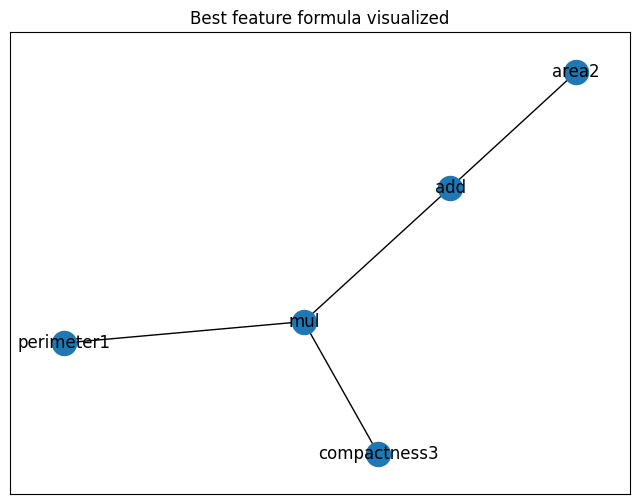

In [7]:
best_feature_func, best_individual = optimizer.evolve_new_feature(epochs=50, heuristics=Benchmark.dtree_accuracy, verbose=False)
print("Feature as math expression:", best_individual, "\n")

nodes, edges, labels = gp.graph(best_individual)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.spring_layout(g)

plt.figure(figsize=(8, 6))
plt.title("Best feature formula visualized")
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [ ]:
optimizer_constructor = lambda x_train, x_val, y_train, y_val: PymooOptimizer(x_train, x_val, y_train, y_val)
x_train_2, x_test_2, x_val_2 = fe.evolve_new_feature_set(optimizer_constructor, x_train, x_val, y_train, y_val, x_test, verbose=False,
                                                        heuristics=Benchmark.dtree_accuracy, epochs=50, repeats=heuristics_repeats,
                                                        min_features=3, max_features=10)

score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)
new_score= np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_val, heuristics_repeats) * 100, 2)

print(f'After feature creation, decision tree accuracy was equal to {new_score}%\n\n' +
        f'With previous data, it was {score}%\n\n' +
        f'Optimal contains {100 - np.round(x_train_2.shape[1] / x_train.shape[1] * 100, 1)}% less columns than the original dataset')

After feature creation, decision tree accuracy was equal to 96.99%

With previous data, it was 92.98%

Optimal contains 90.0% less columns than the original dataset, list of columns: evolved_feature_1, evolved_feature_2, evolved_feature_3


In [6]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
from sklearn.metrics import r2_score
MAX_PROCESSES = 1

dataset_name = ['students', 'energy', 'concrete', 'maintenance', 'forest_fires', 'churn', 'wine_qual']

r2_before = []
r2_selection = []
r2_creation = []
evo_forest = []

for dataset in dataset_name:
    success = False
    while not success:
        try:
            x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data(dataset, 0.8, 0.1)
            x_train.columns = x_train.columns.str.replace(' ', '_')
            x_test.columns = x_test.columns.str.replace(' ', '_')
            x_val.columns = x_val.columns.str.replace(' ', '_')

            optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
            solution, score = optimizer.optimize(64, 100, Benchmark.regressor_r2_score, verbose = False, repeats=5)

            raw_score = np.round(Benchmark.regressor_r2_score(x_train, x_test, y_train, y_test, 5), 4)
            optimized_score = np.round(Benchmark.regressor_r2_score(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test, 5), 4)

            optimizer_constructor = lambda x_train, x_val, y_train, y_val: PymooOptimizer(x_train, x_val, y_train, y_val)
            x_train_2, x_test_2, x_val_2 = fe.evolve_new_feature_set(optimizer_constructor, x_train, x_val, y_train, y_val, x_test, verbose=False,
                                                                    heuristics=Benchmark.regressor_r2_score, epochs=50, population_size=64, repeats=5,
                                                                    min_features=2, max_features=20)

            new_score= np.round(Benchmark.regressor_r2_score(x_train_2, x_test_2, y_train, y_val, 5), 4)

            r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                        gene_num=10, boost_size=100, n_gen=50, n_pop=64, cross_pb=1,
                                        base_learner='Random-DT', verbose=False, n_process=MAX_PROCESSES)
            r.fit(x_train, y_train)
            evo_forest_score = np.round(r2_score(y_test, r.predict(x_test)), 4)

            r2_before.append(raw_score)
            r2_selection.append(optimized_score)
            r2_creation.append(new_score)
            evo_forest.append(evo_forest_score)

            print(f'Dataset: {dataset}\n'+
                  f'R2 before: {raw_score}\n'+
                 f'R2 selection: {optimized_score}\n'+
                 f'R2 creation: {new_score}\n'+
                  f'R2 evo forest: {evo_forest_score}\n\n')
            success = True
        except Exception as e:
            print(f"Error {e}, retrying...\n\n")

WARNING
At least one column has heen dropped due to being non-numeric value.


C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: students
R2 before: 0.4909
R2 selection: 0.6794
R2 creation: 0.7643
R2 evo forest: 0.6846


WARNING
At least one column has heen dropped due to being non-numeric value.


C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: energy
R2 before: -0.4958
R2 selection: -0.2211
R2 creation: 0.0626
R2 evo forest: 0.2527




C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: concrete
R2 before: 0.4714
R2 selection: 0.5229
R2 creation: 0.6873
R2 evo forest: 0.7511


WARNING
At least one column has heen dropped due to being non-numeric value.


C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: maintenance
R2 before: 0.9843
R2 selection: 0.9843
R2 creation: 0.9642
R2 evo forest: 0.9625


WARNING
At least one column has heen dropped due to being non-numeric value.


C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: forest_fires
R2 before: -0.4774
R2 selection: -0.2632
R2 creation: 0.105
R2 evo forest: -0.1443




C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: churn
R2 before: 0.3394
R2 selection: 0.2709
R2 creation: 0.4544
R2 evo forest: 0.554




C:\Users\HP\Documents\Python\lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Dataset: wine_qual
R2 before: -0.1916
R2 selection: 0.1411
R2 creation: 0.1605
R2 evo forest: 0.3484




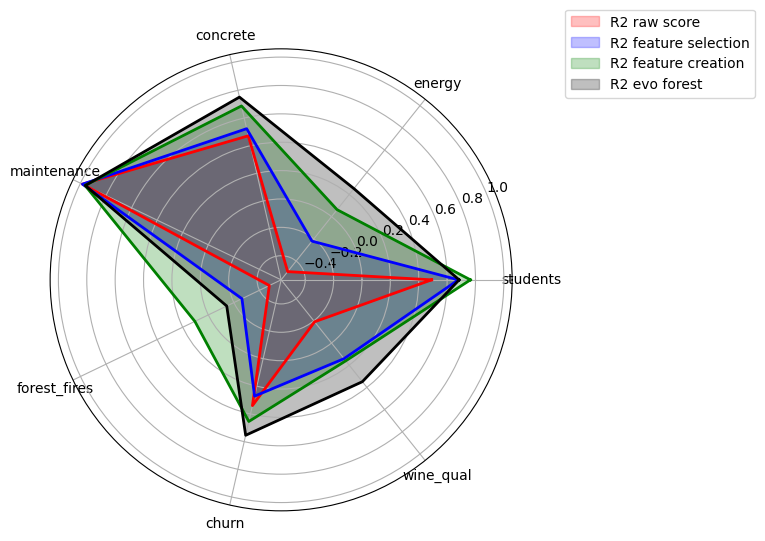

In [15]:
# Number of variables
num_vars = len(dataset_name)

# Compute the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by appending the start to the end
r2_before += [r2_before[0]]
r2_selection += [r2_selection[0]]
r2_creation += [r2_creation[0]]
evo_forest += [evo_forest[0]]
angles += [angles[0]]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Draw each list
ax.fill(angles, r2_before, color='red', alpha=0.25, label='R2 raw score')
ax.plot(angles, r2_before, color='red', linewidth=2, linestyle='solid')

ax.fill(angles, r2_selection, color='blue', alpha=0.25, label='R2 feature selection')
ax.plot(angles, r2_selection, color='blue', linewidth=2, linestyle='solid')

ax.fill(angles, r2_creation, color='green', alpha=0.25, label='R2 feature creation')
ax.plot(angles, r2_creation, color='green', linewidth=2, linestyle='solid')

ax.fill(angles, evo_forest, color='black', alpha=0.25, label='R2 evo forest')
ax.plot(angles, evo_forest, color='black', linewidth=2, linestyle='solid')

# Add labels to each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dataset_name)

ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

plt.show()

In [10]:
import time
dataset_name = ['cirrhosis', 'breast', 'rice', 'bank_marketing', 'aids', 'national_poll']

accuracy_before = []
accuracy_selection = []
accuracy_creation = []

for dataset in dataset_name:
    start = time.time()
    success = False
    while not success:
        try:
            x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data(dataset, 0.8, 0.1)
            x_train.columns = x_train.columns.str.replace(' ', '_')
            x_test.columns = x_test.columns.str.replace(' ', '_')
            x_val.columns = x_val.columns.str.replace(' ', '_')

            optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
            solution, score = optimizer.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=5)

            raw_score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)

            x_train_2, x_val_2, x_test_2 = fe.evolve_new_feature(optimizer, x_test, verbose=False, repeats=heuristics_repeats, name='new_feature')

            score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test, heuristics_repeats) * 100, 2)

            optimizer_2 = PymooOptimizer(x_train_2, x_val_2, y_train, y_val)
            solution, score = optimizer_2.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

            optimized_score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2.loc[:, solution], x_test_2.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)

            
            accuracy_before.append(raw_score)
            accuracy_selection.append(optimized_score_with_new_feature)
            accuracy_creation.append(score_with_new_feature)

            print(f'Dataset: {dataset}\n'+
                  f'Accuracy before: {raw_score}\n'+
                 f'Accuracy creation: {score_with_new_feature}\n'+
                 f'Accuracy creation and selection: {optimized_score_with_new_feature}\n\n')
            success = True
        except Exception as e:
            print(f"Error {e}, retrying...\n\n")
    end = time.time()
    print(f"Time taken: {(end-start)*10**3:.03f}ms")

WARNING
At least one column has heen dropped due to being non-numeric value.
WARNING
Some records have been removed due to them containing NA values.
Dataset: cirrhosis
Accuracy before: 55.56
Accuracy creation: 65.08
Accuracy creation and selection: 65.08


Time taken: 77491.347ms
Dataset: breast
Accuracy before: 92.11
Accuracy creation: 93.86
Accuracy creation and selection: 92.98


Time taken: 81083.270ms
Dataset: rice
Accuracy before: 88.45
Accuracy creation: 87.66
Accuracy creation and selection: 88.71


Time taken: 120328.994ms
WARNING
At least one column has heen dropped due to being non-numeric value.
Dataset: bank_marketing
Accuracy before: 85.05
Accuracy creation: 85.05
Accuracy creation and selection: 87.91


Time taken: 1602546.899ms
Dataset: aids
Accuracy before: 82.24
Accuracy creation: 83.88
Accuracy creation and selection: 83.88


Time taken: 109279.121ms
Dataset: national_poll
Accuracy before: 37.06
Accuracy creation: 46.15
Accuracy creation and selection: 57.34


Time 

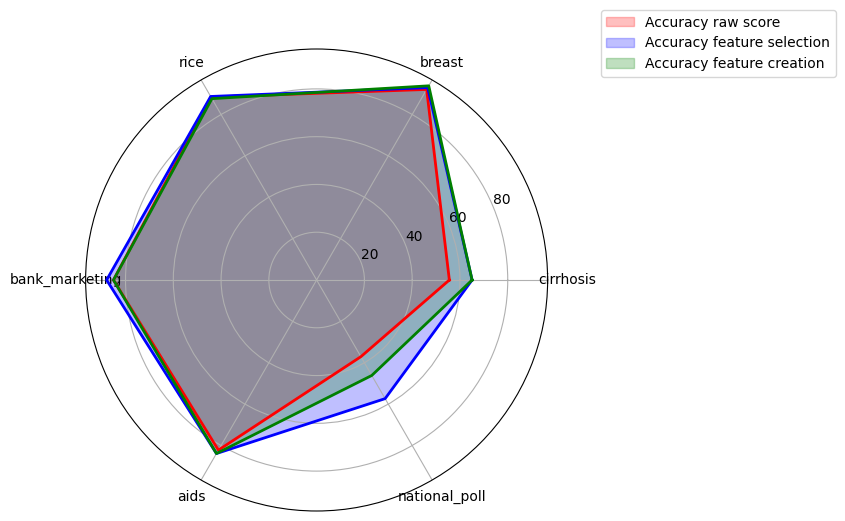

In [11]:
# Number of variables
num_vars = len(dataset_name)

# Compute the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by appending the start to the end
accuracy_before += [accuracy_before[0]]
accuracy_selection += [accuracy_selection[0]]
accuracy_creation += [accuracy_creation[0]]
angles += [angles[0]]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Draw each list
ax.fill(angles, accuracy_before, color='red', alpha=0.25, label='Accuracy raw score')
ax.plot(angles, accuracy_before, color='red', linewidth=2, linestyle='solid')

ax.fill(angles, accuracy_selection, color='blue', alpha=0.25, label='Accuracy feature selection')
ax.plot(angles, accuracy_selection, color='blue', linewidth=2, linestyle='solid')

ax.fill(angles, accuracy_creation, color='green', alpha=0.25, label='Accuracy feature creation')
ax.plot(angles, accuracy_creation, color='green', linewidth=2, linestyle='solid')

# Add labels to each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dataset_name)

ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

plt.show()